In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=0.3 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.000e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 34225 
    Total predicted counts          : 34257.54
    Total off counts                : 101613.00

    Total background counts         : 20322.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 2000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 7.67 s, sys: 82.2 ms, total: 7.75 s
Wall time: 7.75 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 34383 
    Total predicted counts          : 34347.94
    Total off counts                : 102065.00

    Total background counts         : 20413.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 34005 
    Total predicted counts          : 34232.74
    Total off counts                : 101489.00

    Total background counts         : 20

SpectrumDatasetOnOff

    Name                            : obs_28 

    Total counts                    : 34273 
    Total predicted counts          : 34309.54
    Total off counts                : 101873.00

    Total background counts         : 20374.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_29 

    Total counts                    : 34251 
    Total predicted counts          : 34145.94
    Total off counts                : 101055.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_61 

    Total counts                    : 34681 
    Total predicted counts          : 34101.74
    Total off counts                : 100834.00

    Total background counts         : 20166.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 20.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_62 

    Total counts                    : 34485 
    Total predicted counts          : 34236.74
    Total off counts                : 101509.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_93 

    Total counts                    : 34396 
    Total predicted counts          : 34193.94
    Total off counts                : 101295.00

    Total background counts         : 20259.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_94 

    Total counts                    : 34315 
    Total predicted counts          : 34185.94
    Total off counts                : 101255.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_125 

    Total counts                    : 34266 
    Total predicted counts          : 34230.54
    Total off counts                : 101478.00

    Total background counts         : 20295.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_126 

    Total counts                    : 34178 
    Total predicted counts          : 34197.54
    Total off counts                : 101313.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_144 

    Total counts                    : 34218 
    Total predicted counts          : 34223.34
    Total off counts                : 101442.00

    Total background counts         : 20288.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_145 

    Total counts                    : 34276 
    Total predicted counts          : 34351.14
    Total off counts                : 102081.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_162 

    Total counts                    : 34433 
    Total predicted counts          : 34235.34
    Total off counts                : 101502.00

    Total background counts         : 20300.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_163 

    Total counts                    : 34233 
    Total predicted counts          : 34299.34
    Total off counts                : 101822.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_180 

    Total counts                    : 34241 
    Total predicted counts          : 34271.54
    Total off counts                : 101683.00

    Total background counts         : 20336.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_181 

    Total counts                    : 34070 
    Total predicted counts          : 34291.14
    Total off counts                : 101781.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_197 

    Total counts                    : 34412 
    Total predicted counts          : 34267.54
    Total off counts                : 101663.00

    Total background counts         : 20332.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_198 

    Total counts                    : 34096 
    Total predicted counts          : 34093.14
    Total off counts                : 100791.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_215 

    Total counts                    : 34064 
    Total predicted counts          : 34217.14
    Total off counts                : 101411.00

    Total background counts         : 20282.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_216 

    Total counts                    : 34242 
    Total predicted counts          : 34195.74
    Total off counts                : 101304.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_234 

    Total counts                    : 34483 
    Total predicted counts          : 34275.14
    Total off counts                : 101701.00

    Total background counts         : 20340.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_235 

    Total counts                    : 34137 
    Total predicted counts          : 34130.34
    Total off counts                : 100977.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_253 

    Total counts                    : 33986 
    Total predicted counts          : 34352.54
    Total off counts                : 102088.00

    Total background counts         : 20417.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_254 

    Total counts                    : 34310 
    Total predicted counts          : 34245.14
    Total off counts                : 101551.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_273 

    Total counts                    : 34283 
    Total predicted counts          : 34284.34
    Total off counts                : 101747.00

    Total background counts         : 20349.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_274 

    Total counts                    : 34191 
    Total predicted counts          : 34321.34
    Total off counts                : 101932.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_289 

    Total counts                    : 34380 
    Total predicted counts          : 34246.54
    Total off counts                : 101558.00

    Total background counts         : 20311.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_290 

    Total counts                    : 34415 
    Total predicted counts          : 34225.94
    Total off counts                : 101455.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_307 

    Total counts                    : 34465 
    Total predicted counts          : 34304.74
    Total off counts                : 101849.00

    Total background counts         : 20369.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_308 

    Total counts                    : 34134 
    Total predicted counts          : 34098.14
    Total off counts                : 100816.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_326 

    Total counts                    : 34424 
    Total predicted counts          : 34225.74
    Total off counts                : 101454.00

    Total background counts         : 20290.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_327 

    Total counts                    : 34018 
    Total predicted counts          : 34219.34
    Total off counts                : 101422.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_343 

    Total counts                    : 34169 
    Total predicted counts          : 34246.14
    Total off counts                : 101556.00

    Total background counts         : 20311.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_344 

    Total counts                    : 34165 
    Total predicted counts          : 34234.14
    Total off counts                : 101496.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_360 

    Total counts                    : 34345 
    Total predicted counts          : 34204.94
    Total off counts                : 101350.00

    Total background counts         : 20270.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_361 

    Total counts                    : 34544 
    Total predicted counts          : 34196.34
    Total off counts                : 101307.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_379 

    Total counts                    : 34326 
    Total predicted counts          : 34253.34
    Total off counts                : 101592.00

    Total background counts         : 20318.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_380 

    Total counts                    : 34294 
    Total predicted counts          : 34373.54
    Total off counts                : 102193.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_394 

    Total counts                    : 33942 
    Total predicted counts          : 34241.14
    Total off counts                : 101531.00

    Total background counts         : 20306.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_395 

    Total counts                    : 34232 
    Total predicted counts          : 34238.34
    Total off counts                : 101517.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_411 

    Total counts                    : 34437 
    Total predicted counts          : 34357.54
    Total off counts                : 102113.00

    Total background counts         : 20422.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_412 

    Total counts                    : 34324 
    Total predicted counts          : 34189.74
    Total off counts                : 101274.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_436 

    Total counts                    : 34056 
    Total predicted counts          : 34329.54
    Total off counts                : 101973.00

    Total background counts         : 20394.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_437 

    Total counts                    : 34269 
    Total predicted counts          : 34344.94
    Total off counts                : 102050.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_455 

    Total counts                    : 34177 
    Total predicted counts          : 34334.54
    Total off counts                : 101998.00

    Total background counts         : 20399.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_456 

    Total counts                    : 34300 
    Total predicted counts          : 34280.54
    Total off counts                : 101728.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_472 

    Total counts                    : 34083 
    Total predicted counts          : 34270.94
    Total off counts                : 101680.00

    Total background counts         : 20336.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_473 

    Total counts                    : 34383 
    Total predicted counts          : 34263.54
    Total off counts                : 101643.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_495 

    Total counts                    : 34485 
    Total predicted counts          : 34191.54
    Total off counts                : 101283.00

    Total background counts         : 20256.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_496 

    Total counts                    : 34274 
    Total predicted counts          : 34237.54
    Total off counts                : 101513.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_514 

    Total counts                    : 33913 
    Total predicted counts          : 34235.34
    Total off counts                : 101502.00

    Total background counts         : 20300.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_515 

    Total counts                    : 34295 
    Total predicted counts          : 34332.54
    Total off counts                : 101988.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_534 

    Total counts                    : 34554 
    Total predicted counts          : 34258.34
    Total off counts                : 101617.00

    Total background counts         : 20323.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_535 

    Total counts                    : 34289 
    Total predicted counts          : 34188.14
    Total off counts                : 101266.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_554 

    Total counts                    : 34045 
    Total predicted counts          : 34249.14
    Total off counts                : 101571.00

    Total background counts         : 20314.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_555 

    Total counts                    : 34300 
    Total predicted counts          : 34112.34
    Total off counts                : 100887.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_571 

    Total counts                    : 34075 
    Total predicted counts          : 34322.54
    Total off counts                : 101938.00

    Total background counts         : 20387.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_572 

    Total counts                    : 34444 
    Total predicted counts          : 34259.14
    Total off counts                : 101621.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_589 

    Total counts                    : 34405 
    Total predicted counts          : 34250.14
    Total off counts                : 101576.00

    Total background counts         : 20315.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_590 

    Total counts                    : 34346 
    Total predicted counts          : 34225.14
    Total off counts                : 101451.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_610 

    Total counts                    : 34234 
    Total predicted counts          : 34327.54
    Total off counts                : 101963.00

    Total background counts         : 20392.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_611 

    Total counts                    : 34347 
    Total predicted counts          : 34180.14
    Total off counts                : 101226.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_630 

    Total counts                    : 34223 
    Total predicted counts          : 34342.94
    Total off counts                : 102040.00

    Total background counts         : 20408.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_631 

    Total counts                    : 34131 
    Total predicted counts          : 34297.34
    Total off counts                : 101812.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_650 

    Total counts                    : 34311 
    Total predicted counts          : 34293.34
    Total off counts                : 101792.00

    Total background counts         : 20358.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_651 

    Total counts                    : 34533 
    Total predicted counts          : 34247.94
    Total off counts                : 101565.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_670 

    Total counts                    : 34333 
    Total predicted counts          : 34216.34
    Total off counts                : 101407.00

    Total background counts         : 20281.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_671 

    Total counts                    : 34203 
    Total predicted counts          : 34348.74
    Total off counts                : 102069.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_690 

    Total counts                    : 34260 
    Total predicted counts          : 34247.94
    Total off counts                : 101565.00

    Total background counts         : 20313.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_691 

    Total counts                    : 34026 
    Total predicted counts          : 34255.14
    Total off counts                : 101601.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_707 

    Total counts                    : 34117 
    Total predicted counts          : 34191.74
    Total off counts                : 101284.00

    Total background counts         : 20256.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_708 

    Total counts                    : 34218 
    Total predicted counts          : 34206.54
    Total off counts                : 101358.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_739 

    Total counts                    : 34339 
    Total predicted counts          : 34248.74
    Total off counts                : 101569.00

    Total background counts         : 20313.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_740 

    Total counts                    : 34339 
    Total predicted counts          : 34212.54
    Total off counts                : 101388.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_750 

    Total counts                    : 34607 
    Total predicted counts          : 34188.54
    Total off counts                : 101268.00

    Total background counts         : 20253.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_751 

    Total counts                    : 34501 
    Total predicted counts          : 34288.14
    Total off counts                : 101766.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_771 

    Total counts                    : 34459 
    Total predicted counts          : 34279.54
    Total off counts                : 101723.00

    Total background counts         : 20344.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_772 

    Total counts                    : 34303 
    Total predicted counts          : 34320.54
    Total off counts                : 101928.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_792 

    Total counts                    : 34359 
    Total predicted counts          : 34222.54
    Total off counts                : 101438.00

    Total background counts         : 20287.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_793 

    Total counts                    : 34230 
    Total predicted counts          : 34321.34
    Total off counts                : 101932.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_819 

    Total counts                    : 34058 
    Total predicted counts          : 34242.14
    Total off counts                : 101536.00

    Total background counts         : 20307.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_820 

    Total counts                    : 34284 
    Total predicted counts          : 34127.54
    Total off counts                : 100963.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_845 

    Total counts                    : 34288 
    Total predicted counts          : 34225.54
    Total off counts                : 101453.00

    Total background counts         : 20290.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_846 

    Total counts                    : 34144 
    Total predicted counts          : 34093.54
    Total off counts                : 100793.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_868 

    Total counts                    : 34149 
    Total predicted counts          : 34243.14
    Total off counts                : 101541.00

    Total background counts         : 20308.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_869 

    Total counts                    : 34154 
    Total predicted counts          : 34265.74
    Total off counts                : 101654.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_889 

    Total counts                    : 34317 
    Total predicted counts          : 34157.34
    Total off counts                : 101112.00

    Total background counts         : 20222.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_890 

    Total counts                    : 34130 
    Total predicted counts          : 34290.74
    Total off counts                : 101779.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_909 

    Total counts                    : 34163 
    Total predicted counts          : 34302.94
    Total off counts                : 101840.00

    Total background counts         : 20368.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_910 

    Total counts                    : 34146 
    Total predicted counts          : 34311.74
    Total off counts                : 101884.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_929 

    Total counts                    : 34054 
    Total predicted counts          : 34266.94
    Total off counts                : 101660.00

    Total background counts         : 20332.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_930 

    Total counts                    : 34354 
    Total predicted counts          : 34218.54
    Total off counts                : 101418.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_950 

    Total counts                    : 33932 
    Total predicted counts          : 34257.94
    Total off counts                : 101615.00

    Total background counts         : 20323.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_951 

    Total counts                    : 34066 
    Total predicted counts          : 34302.14
    Total off counts                : 101836.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_969 

    Total counts                    : 34284 
    Total predicted counts          : 34210.54
    Total off counts                : 101378.00

    Total background counts         : 20275.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_970 

    Total counts                    : 34366 
    Total predicted counts          : 34182.34
    Total off counts                : 101237.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_988 

    Total counts                    : 34246 
    Total predicted counts          : 34290.34
    Total off counts                : 101777.00

    Total background counts         : 20355.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_989 

    Total counts                    : 34030 
    Total predicted counts          : 34227.14
    Total off counts                : 101461.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_1009 

    Total counts                    : 34206 
    Total predicted counts          : 34185.34
    Total off counts                : 101252.00

    Total background counts         : 20250.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1010 

    Total counts                    : 34079 
    Total predicted counts          : 34227.14
    Total off counts                : 101461.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1030 

    Total counts                    : 34230 
    Total predicted counts          : 34269.14
    Total off counts                : 101671.00

    Total background counts         : 20334.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1031 

    Total counts                    : 34130 
    Total predicted counts          : 34185.74
    Total off counts                : 101254.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1049 

    Total counts                    : 34290 
    Total predicted counts          : 34200.14
    Total off counts                : 101326.00

    Total background counts         : 20265.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1050 

    Total counts                    : 34332 
    Total predicted counts          : 34230.34
    Total off counts                : 101477.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1069 

    Total counts                    : 33886 
    Total predicted counts          : 34341.74
    Total off counts                : 102034.00

    Total background counts         : 20406.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1070 

    Total counts                    : 34340 
    Total predicted counts          : 34214.34
    Total off counts                : 101397.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1088 

    Total counts                    : 34492 
    Total predicted counts          : 34207.14
    Total off counts                : 101361.00

    Total background counts         : 20272.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1089 

    Total counts                    : 34026 
    Total predicted counts          : 34172.74
    Total off counts                : 101189.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1108 

    Total counts                    : 34337 
    Total predicted counts          : 34315.94
    Total off counts                : 101905.00

    Total background counts         : 20381.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1109 

    Total counts                    : 34345 
    Total predicted counts          : 34321.54
    Total off counts                : 101933.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1128 

    Total counts                    : 34418 
    Total predicted counts          : 34329.94
    Total off counts                : 101975.00

    Total background counts         : 20395.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1129 

    Total counts                    : 34322 
    Total predicted counts          : 34269.14
    Total off counts                : 101671.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1147 

    Total counts                    : 34315 
    Total predicted counts          : 34356.74
    Total off counts                : 102109.00

    Total background counts         : 20421.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1148 

    Total counts                    : 33996 
    Total predicted counts          : 34306.74
    Total off counts                : 101859.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1167 

    Total counts                    : 33640 
    Total predicted counts          : 34147.34
    Total off counts                : 101062.00

    Total background counts         : 20212.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1168 

    Total counts                    : 34219 
    Total predicted counts          : 34206.94
    Total off counts                : 101360.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1186 

    Total counts                    : 34309 
    Total predicted counts          : 34234.14
    Total off counts                : 101496.00

    Total background counts         : 20299.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1187 

    Total counts                    : 34199 
    Total predicted counts          : 34152.74
    Total off counts                : 101089.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1206 

    Total counts                    : 34206 
    Total predicted counts          : 34360.54
    Total off counts                : 102128.00

    Total background counts         : 20425.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1207 

    Total counts                    : 34147 
    Total predicted counts          : 34217.14
    Total off counts                : 101411.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1226 

    Total counts                    : 34063 
    Total predicted counts          : 34322.14
    Total off counts                : 101936.00

    Total background counts         : 20387.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1227 

    Total counts                    : 34292 
    Total predicted counts          : 34223.94
    Total off counts                : 101445.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1246 

    Total counts                    : 34518 
    Total predicted counts          : 34170.94
    Total off counts                : 101180.00

    Total background counts         : 20236.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1247 

    Total counts                    : 34197 
    Total predicted counts          : 34247.34
    Total off counts                : 101562.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1264 

    Total counts                    : 34102 
    Total predicted counts          : 34261.14
    Total off counts                : 101631.00

    Total background counts         : 20326.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1265 

    Total counts                    : 34205 
    Total predicted counts          : 34371.74
    Total off counts                : 102184.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1283 

    Total counts                    : 34335 
    Total predicted counts          : 34400.54
    Total off counts                : 102328.00

    Total background counts         : 20465.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1284 

    Total counts                    : 34265 
    Total predicted counts          : 34191.74
    Total off counts                : 101284.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1300 

    Total counts                    : 34224 
    Total predicted counts          : 34201.94
    Total off counts                : 101335.00

    Total background counts         : 20267.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1301 

    Total counts                    : 34344 
    Total predicted counts          : 34296.34
    Total off counts                : 101807.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1316 

    Total counts                    : 34071 
    Total predicted counts          : 34287.34
    Total off counts                : 101762.00

    Total background counts         : 20352.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1317 

    Total counts                    : 34527 
    Total predicted counts          : 34296.94
    Total off counts                : 101810.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1331 

    Total counts                    : 34272 
    Total predicted counts          : 34221.34
    Total off counts                : 101432.00

    Total background counts         : 20286.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1332 

    Total counts                    : 34329 
    Total predicted counts          : 34317.94
    Total off counts                : 101915.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1346 

    Total counts                    : 34188 
    Total predicted counts          : 34206.14
    Total off counts                : 101356.00

    Total background counts         : 20271.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1347 

    Total counts                    : 34181 
    Total predicted counts          : 34242.54
    Total off counts                : 101538.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1364 

    Total counts                    : 34024 
    Total predicted counts          : 34206.54
    Total off counts                : 101358.00

    Total background counts         : 20271.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1365 

    Total counts                    : 34515 
    Total predicted counts          : 34211.74
    Total off counts                : 101384.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1382 

    Total counts                    : 34121 
    Total predicted counts          : 34244.54
    Total off counts                : 101548.00

    Total background counts         : 20309.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1383 

    Total counts                    : 34578 
    Total predicted counts          : 34203.94
    Total off counts                : 101345.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1400 

    Total counts                    : 33988 
    Total predicted counts          : 34144.74
    Total off counts                : 101049.00

    Total background counts         : 20209.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1401 

    Total counts                    : 34305 
    Total predicted counts          : 34124.14
    Total off counts                : 100946.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1418 

    Total counts                    : 34258 
    Total predicted counts          : 34247.34
    Total off counts                : 101562.00

    Total background counts         : 20312.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1419 

    Total counts                    : 34310 
    Total predicted counts          : 34232.14
    Total off counts                : 101486.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1434 

    Total counts                    : 34136 
    Total predicted counts          : 34230.34
    Total off counts                : 101477.00

    Total background counts         : 20295.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1435 

    Total counts                    : 34163 
    Total predicted counts          : 34299.94
    Total off counts                : 101825.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1452 

    Total counts                    : 33909 
    Total predicted counts          : 34189.34
    Total off counts                : 101272.00

    Total background counts         : 20254.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1453 

    Total counts                    : 34199 
    Total predicted counts          : 34255.94
    Total off counts                : 101605.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1470 

    Total counts                    : 34319 
    Total predicted counts          : 34176.34
    Total off counts                : 101207.00

    Total background counts         : 20241.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1471 

    Total counts                    : 33906 
    Total predicted counts          : 34194.34
    Total off counts                : 101297.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1484 

    Total counts                    : 34323 
    Total predicted counts          : 34203.54
    Total off counts                : 101343.00

    Total background counts         : 20268.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1485 

    Total counts                    : 33964 
    Total predicted counts          : 34298.94
    Total off counts                : 101820.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1502 

    Total counts                    : 34104 
    Total predicted counts          : 34132.74
    Total off counts                : 100989.00

    Total background counts         : 20197.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1503 

    Total counts                    : 34250 
    Total predicted counts          : 34249.54
    Total off counts                : 101573.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1520 

    Total counts                    : 34356 
    Total predicted counts          : 34206.14
    Total off counts                : 101356.00

    Total background counts         : 20271.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1521 

    Total counts                    : 34394 
    Total predicted counts          : 34340.14
    Total off counts                : 102026.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1532 

    Total counts                    : 34455 
    Total predicted counts          : 34224.34
    Total off counts                : 101447.00

    Total background counts         : 20289.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1533 

    Total counts                    : 34246 
    Total predicted counts          : 34317.94
    Total off counts                : 101915.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1544 

    Total counts                    : 34067 
    Total predicted counts          : 34256.34
    Total off counts                : 101607.00

    Total background counts         : 20321.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1545 

    Total counts                    : 34101 
    Total predicted counts          : 34298.54
    Total off counts                : 101818.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1563 

    Total counts                    : 34196 
    Total predicted counts          : 34333.54
    Total off counts                : 101993.00

    Total background counts         : 20398.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1564 

    Total counts                    : 34202 
    Total predicted counts          : 34252.34
    Total off counts                : 101587.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1583 

    Total counts                    : 34182 
    Total predicted counts          : 34355.54
    Total off counts                : 102103.00

    Total background counts         : 20420.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1584 

    Total counts                    : 34002 
    Total predicted counts          : 34243.14
    Total off counts                : 101541.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1599 

    Total counts                    : 34252 
    Total predicted counts          : 34274.34
    Total off counts                : 101697.00

    Total background counts         : 20339.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1600 

    Total counts                    : 34361 
    Total predicted counts          : 34224.94
    Total off counts                : 101450.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1612 

    Total counts                    : 33913 
    Total predicted counts          : 34193.14
    Total off counts                : 101291.00

    Total background counts         : 20258.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1613 

    Total counts                    : 34330 
    Total predicted counts          : 34222.54
    Total off counts                : 101438.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1626 

    Total counts                    : 34378 
    Total predicted counts          : 34246.54
    Total off counts                : 101558.00

    Total background counts         : 20311.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1627 

    Total counts                    : 34386 
    Total predicted counts          : 34360.94
    Total off counts                : 102130.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1639 

    Total counts                    : 34211 
    Total predicted counts          : 34288.94
    Total off counts                : 101770.00

    Total background counts         : 20354.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1640 

    Total counts                    : 34675 
    Total predicted counts          : 34249.74
    Total off counts                : 101574.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1656 

    Total counts                    : 34062 
    Total predicted counts          : 34337.94
    Total off counts                : 102015.00

    Total background counts         : 20403.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1657 

    Total counts                    : 34303 
    Total predicted counts          : 34284.14
    Total off counts                : 101746.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1670 

    Total counts                    : 34050 
    Total predicted counts          : 34313.74
    Total off counts                : 101894.00

    Total background counts         : 20378.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1671 

    Total counts                    : 34070 
    Total predicted counts          : 34241.94
    Total off counts                : 101535.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1683 

    Total counts                    : 34299 
    Total predicted counts          : 34264.54
    Total off counts                : 101648.00

    Total background counts         : 20329.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1684 

    Total counts                    : 33968 
    Total predicted counts          : 34291.34
    Total off counts                : 101782.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1698 

    Total counts                    : 34380 
    Total predicted counts          : 34109.14
    Total off counts                : 100871.00

    Total background counts         : 20174.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1699 

    Total counts                    : 34256 
    Total predicted counts          : 34246.34
    Total off counts                : 101557.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1712 

    Total counts                    : 34275 
    Total predicted counts          : 34230.94
    Total off counts                : 101480.00

    Total background counts         : 20296.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1713 

    Total counts                    : 34176 
    Total predicted counts          : 34191.34
    Total off counts                : 101282.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1728 

    Total counts                    : 34173 
    Total predicted counts          : 34197.54
    Total off counts                : 101313.00

    Total background counts         : 20262.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1729 

    Total counts                    : 34235 
    Total predicted counts          : 34154.14
    Total off counts                : 101096.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1740 

    Total counts                    : 34387 
    Total predicted counts          : 34341.54
    Total off counts                : 102033.00

    Total background counts         : 20406.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1741 

    Total counts                    : 34246 
    Total predicted counts          : 34252.74
    Total off counts                : 101589.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1753 

    Total counts                    : 34106 
    Total predicted counts          : 34241.74
    Total off counts                : 101534.00

    Total background counts         : 20306.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1754 

    Total counts                    : 33738 
    Total predicted counts          : 34178.74
    Total off counts                : 101219.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1766 

    Total counts                    : 34379 
    Total predicted counts          : 34204.14
    Total off counts                : 101346.00

    Total background counts         : 20269.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1767 

    Total counts                    : 34251 
    Total predicted counts          : 34209.74
    Total off counts                : 101374.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1779 

    Total counts                    : 34158 
    Total predicted counts          : 34133.14
    Total off counts                : 100991.00

    Total background counts         : 20198.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1780 

    Total counts                    : 34165 
    Total predicted counts          : 34272.14
    Total off counts                : 101686.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1792 

    Total counts                    : 34434 
    Total predicted counts          : 34165.14
    Total off counts                : 101151.00

    Total background counts         : 20230.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1793 

    Total counts                    : 34296 
    Total predicted counts          : 34136.14
    Total off counts                : 101006.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1804 

    Total counts                    : 34219 
    Total predicted counts          : 34351.14
    Total off counts                : 102081.00

    Total background counts         : 20416.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1805 

    Total counts                    : 34167 
    Total predicted counts          : 34220.94
    Total off counts                : 101430.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1819 

    Total counts                    : 34321 
    Total predicted counts          : 34267.34
    Total off counts                : 101662.00

    Total background counts         : 20332.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1820 

    Total counts                    : 34171 
    Total predicted counts          : 34269.94
    Total off counts                : 101675.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1844 

    Total counts                    : 34313 
    Total predicted counts          : 34285.94
    Total off counts                : 101755.00

    Total background counts         : 20351.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1845 

    Total counts                    : 34183 
    Total predicted counts          : 34203.34
    Total off counts                : 101342.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1856 

    Total counts                    : 33948 
    Total predicted counts          : 34212.14
    Total off counts                : 101386.00

    Total background counts         : 20277.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1857 

    Total counts                    : 34747 
    Total predicted counts          : 34185.94
    Total off counts                : 101255.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1872 

    Total counts                    : 34200 
    Total predicted counts          : 34198.94
    Total off counts                : 101320.00

    Total background counts         : 20264.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1873 

    Total counts                    : 34182 
    Total predicted counts          : 34267.54
    Total off counts                : 101663.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1885 

    Total counts                    : 34066 
    Total predicted counts          : 34169.54
    Total off counts                : 101173.00

    Total background counts         : 20234.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1886 

    Total counts                    : 34620 
    Total predicted counts          : 34225.54
    Total off counts                : 101453.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1900 

    Total counts                    : 34097 
    Total predicted counts          : 34191.94
    Total off counts                : 101285.00

    Total background counts         : 20257.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1901 

    Total counts                    : 34061 
    Total predicted counts          : 34187.54
    Total off counts                : 101263.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1913 

    Total counts                    : 34326 
    Total predicted counts          : 34202.94
    Total off counts                : 101340.00

    Total background counts         : 20268.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1914 

    Total counts                    : 34342 
    Total predicted counts          : 34170.34
    Total off counts                : 101177.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1927 

    Total counts                    : 34027 
    Total predicted counts          : 34303.74
    Total off counts                : 101844.00

    Total background counts         : 20368.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1928 

    Total counts                    : 34359 
    Total predicted counts          : 34297.74
    Total off counts                : 101814.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1941 

    Total counts                    : 34210 
    Total predicted counts          : 34155.94
    Total off counts                : 101105.00

    Total background counts         : 20221.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1942 

    Total counts                    : 34441 
    Total predicted counts          : 34233.54
    Total off counts                : 101493.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1955 

    Total counts                    : 34189 
    Total predicted counts          : 34231.54
    Total off counts                : 101483.00

    Total background counts         : 20296.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1956 

    Total counts                    : 34365 
    Total predicted counts          : 34260.74
    Total off counts                : 101629.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1969 

    Total counts                    : 34216 
    Total predicted counts          : 34242.94
    Total off counts                : 101540.00

    Total background counts         : 20308.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1970 

    Total counts                    : 34171 
    Total predicted counts          : 34198.54
    Total off counts                : 101318.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1983 

    Total counts                    : 34122 
    Total predicted counts          : 34249.74
    Total off counts                : 101574.00

    Total background counts         : 20314.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1984 

    Total counts                    : 33855 
    Total predicted counts          : 34237.34
    Total off counts                : 101512.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1995 

    Total counts                    : 33960 
    Total predicted counts          : 34236.74
    Total off counts                : 101509.00

    Total background counts         : 20301.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1996 

    Total counts                    : 34117 
    Total predicted counts          : 34268.94
    Total off counts                : 101670.00

    Total background counts       

Text(0, 0.5, 'No. of observations')

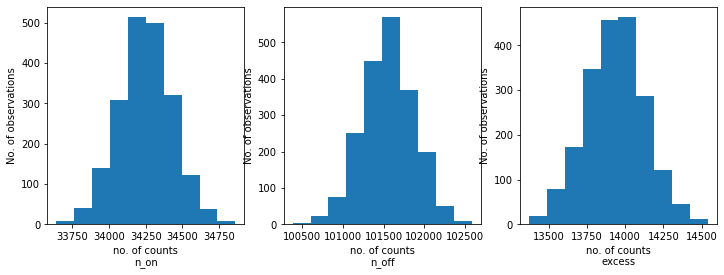

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 8min 29s, sys: 1.08 s, total: 8min 31s
Wall time: 9min 11s


In [15]:
results

[{'index': 2.2169905875495766,
  'amplitude': 1.2845712545260467e-12,
  'lambda_': 0.2801792257657554},
 {'index': 2.2324943380030526,
  'amplitude': 1.2364897746094746e-12,
  'lambda_': 0.28570927813929065},
 {'index': 2.236715787152109,
  'amplitude': 1.2640466245835502e-12,
  'lambda_': 0.3058093664482174},
 {'index': 2.2262640878970683,
  'amplitude': 1.2624740793001813e-12,
  'lambda_': 0.302405819333618},
 {'index': 2.2385731783387843,
  'amplitude': 1.276663483135211e-12,
  'lambda_': 0.30673699196054943},
 {'index': 2.1992461618258976,
  'amplitude': 1.3302284553934254e-12,
  'lambda_': 0.3431724199735729},
 {'index': 2.2416099341604867,
  'amplitude': 1.243665549675842e-12,
  'lambda_': 0.2871674134846505},
 {'index': 2.2238247278324987,
  'amplitude': 1.2845374429121784e-12,
  'lambda_': 0.3019087052854374},
 {'index': 2.2235248230739075,
  'amplitude': 1.248766419923766e-12,
  'lambda_': 0.27479277111955186},
 {'index': 2.2589641058301537,
  'amplitude': 1.1745196406545453e-

index: 2.219328706558498 += 0.018078284685233065


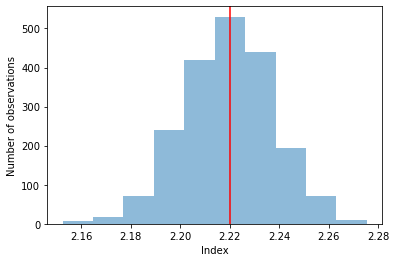

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.2920013943674622e-12 += 4.724558826208461e-14


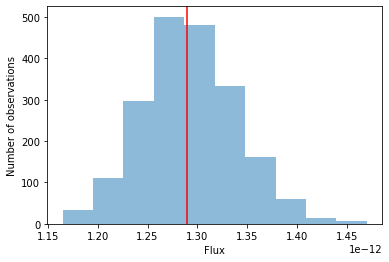

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 0.3014339967323534 += 0.02268318668315472


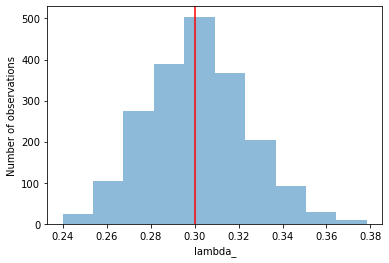

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")